In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

# Synthetic target: sum of two Gaussians at input plane, then fit
import jax
import jax.numpy as jnp
from temgym_core.components import Detector, Lens
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image

import numpy as np

jax.config.update("jax_enable_x64", True)

In [2]:
def smiley(size):
    '''
    Smiley face test object from https://doi.org/10.1093/micmic/ozad021
    '''
    obj = np.ones((size, size), dtype=np.complex64)
    y, x = np.ogrid[-size//2:size//2, -size//2:size//2]

    outline = (((y*1.2)**2 + x**2) > (110/256*size)**2) & \
              (((y*1.2)**2 + x**2) < (120/256*size)**2)
    obj[outline] = 0.0

    left_eye = ((y + 40/256*size)**2 + (x + 40/256*size)**2) < (20/256*size)**2
    obj[left_eye] = 0
    right_eye = (np.abs(y + 40/256*size) < 15/256*size) & \
                (np.abs(x - 40/256*size) < 30/256*size)
    obj[right_eye] = 0

    nose = (y + 20/256*size + x > 0) & (x < 0) & (y < 10/256*size)

    obj[nose] = (0.05j * x + 0.05j * y)[nose]

    mouth = (((y*1)**2 + x**2) > (50/256*size)**2) & \
            (((y*1)**2 + x**2) < (70/256*size)**2) & \
            (y > 20/256*size)

    obj[mouth] = 0

    tongue = (((y - 50/256*size)**2 + (x - 50/256*size)**2) < (20/256*size)**2) & \
             ((y**2 + x**2) > (70/256*size)**2)
    obj[tongue] = 0

    # This wave modulation introduces a strong signature in the diffraction pattern
    # that allows to confirm the correct scale and orientation.
    signature_wave = np.exp(1j*(3 * y + 7 * x) * 2*np.pi/size)

    obj += 0.3*signature_wave - 0.3

    return obj


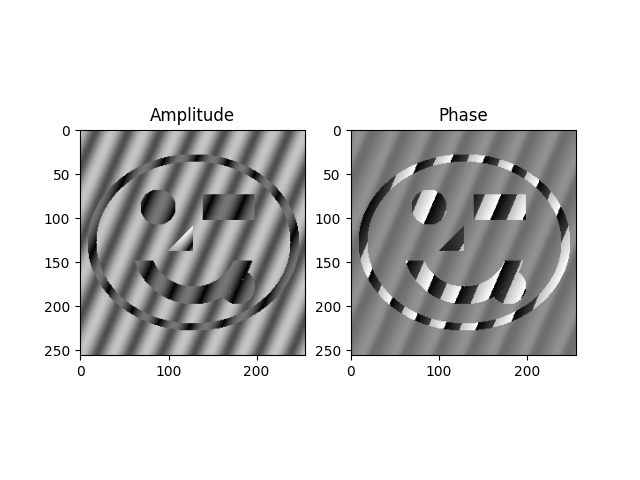

In [3]:
num_px = 256
im = smiley(num_px)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(jnp.abs(im), cmap='gray')
ax[0].set_title('Amplitude')
ax[1].imshow(jnp.angle(im), cmap='gray')
ax[1].set_title('Phase')
plt.show()

In [4]:
wavelength = 2e-12
k = 2 * jnp.pi / wavelength

input_pixel_size = 1e-9
grid = Detector(z=0.0, pixel_size=(input_pixel_size, input_pixel_size), shape=(num_px, num_px))
r1=grid.coords
xs = r1[:, 0]
ys = r1[:, 1]
n_rays = xs.shape[0]
amplitudes = jnp.abs(im).ravel()
phases = jnp.angle(im).ravel()
pathlengths = phases / k

rays = GaussianRay(
    x=xs,
    y=ys,
    dx=jnp.zeros_like(xs),
    dy=jnp.zeros_like(xs),
    z=jnp.zeros_like(xs),
    amplitude=amplitudes,
    pathlength=pathlengths,
    waist_xy = jnp.full((n_rays, 2), (0.5 * input_pixel_size)),
    radii_of_curv=jnp.full((n_rays, 2), (jnp.inf)),
    wavelength=jnp.full((n_rays,), wavelength),
    theta=jnp.zeros(n_rays),
    _one=jnp.ones(n_rays),
)

field = evaluate_gaussian_input_image(rays, grid)

field = field.reshape((num_px, num_px))

amp_diff = jnp.abs(field) - jnp.abs(im)
phase_diff = jnp.angle(field) - jnp.angle(im)

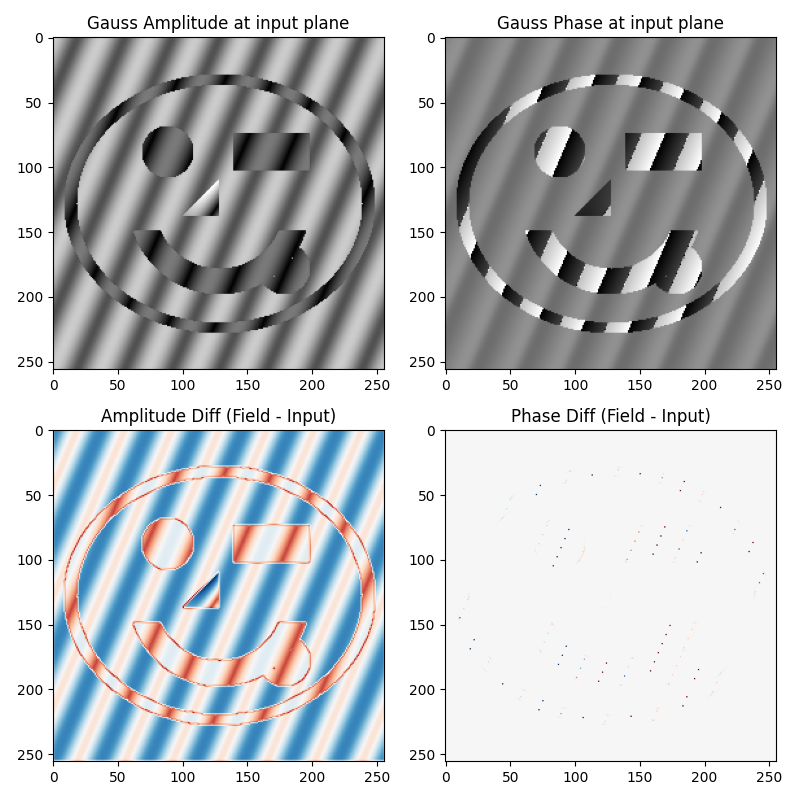

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Amplitude at input plane
ax[0, 0].imshow(jnp.abs(field), cmap='gray')
ax[0, 0].set_title('Gauss Amplitude at input plane')

# Phase at input plane
ax[0, 1].imshow(jnp.angle(field), cmap='gray')
ax[0, 1].set_title('Gauss Phase at input plane')

# Amplitude difference
ax[1, 0].imshow(amp_diff, cmap='RdBu')
ax[1, 0].set_title('Amplitude Diff (Field - Input)')

# Phase difference
ax[1, 1].imshow(phase_diff, cmap='RdBu')
ax[1, 1].set_title('Phase Diff (Field - Input)')

plt.tight_layout()
plt.show()


In [12]:
M1 = -100
F1 = 2.5e-3
M2 = -200
F2 = 1e-2

defocus = 1e-5
L1_z1 = F1 * (1/M1 - 1)
L1_z2 = F1 * (1 - M1)
L2_z1 = F2 * (1/M2 - 1)
L2_z2 = F2 * (1 - M2)

Lens1 = Lens(focal_length=F1, z=abs(L1_z1))
Lens2 = Lens(focal_length=F2, z=abs(L1_z1) + abs(L1_z2) + abs(L2_z1))
detector = Detector(z=abs(L1_z1) + abs(L1_z2) + abs(L2_z1) + abs(L2_z2), pixel_size=(20e-6, 20e-6), shape=(256, 256))
model = [
    Lens1,
    Lens2,
    detector,
]

infocus_image = input_rays = rays.derive(z=jnp.zeros(n_rays) + 1e-10)
det_image_in_focus = make_gaussian_image(input_rays, model, batch_size=1000)

outoffocus_image = input_rays = rays.derive(z=jnp.zeros(n_rays) + defocus)
det_image_out_of_focus = make_gaussian_image(input_rays, model, batch_size=1000)

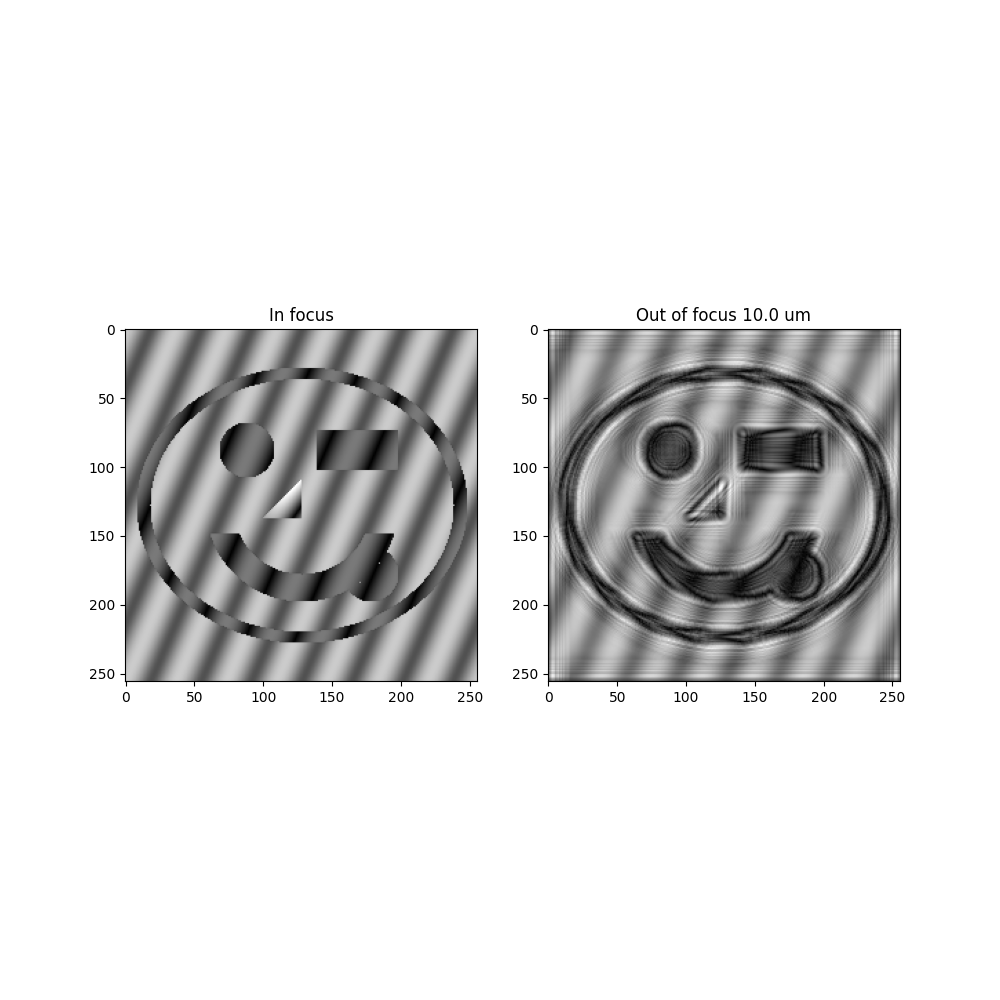

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(jnp.abs(det_image_in_focus), cmap='gray')
ax[0].set_title('In focus')
ax[1].imshow(jnp.abs(det_image_out_of_focus), cmap='gray')
ax[1].set_title('Out of focus {} um'.format(defocus*1e6))
plt.show()